In [1]:
# To make realitve imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, FIG_DIR, COL_STUDENT, COL_SALARY, COL_STUDENT_PRED, COL_SALARY_PRED, SECTORS
from src.model import fitVarModelCompleteDataset, predictWithData
from src.dataLoading import getAllCourses, getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedGrossSalaries
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from tueplots import bundles
import pandas as pd

from statsmodels.graphics.tsaplots import plot_pacf

# Load data for the optimization

In [2]:
courses = getAllCourses() # if you use all options, don't put that in the title down marked  there


interestingYears = YEARS[3:-4]

totalStudents = getTotalStudentsFor(courses = courses, years = interestingYears)

In [3]:
inflationAdjustedGrossSalary= getInflationAdjustedGrossSalaries(SECTORS)

salaries = getSalaries()
salary_YEARS = salaries.index.levels[2]

In [4]:
years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


In [5]:
data = np.column_stack((totalStudents, inflationAdjustedGrossSalary, graduatesInBW.repeat(2)))
completeDataDF = pd.DataFrame(data, index = YEARS[3:-4], columns = ['students', 'salary', 'graduates'])

## PACF for the Students, Salary and Graduates
A PACF plot is used to find statistically significant lags for the hyperparameter optimization. The PACF plot creates a 95% Confidence Interval and all lags which exceed the Confidence Interval are statistically significant. The most promising lag is the last statistically signifcant lag. In a PACF we only look at direct influences, this means, that we are only looking at the influence from $S_{n-1}$ on $S_n$.

In [6]:
# tueplot
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))

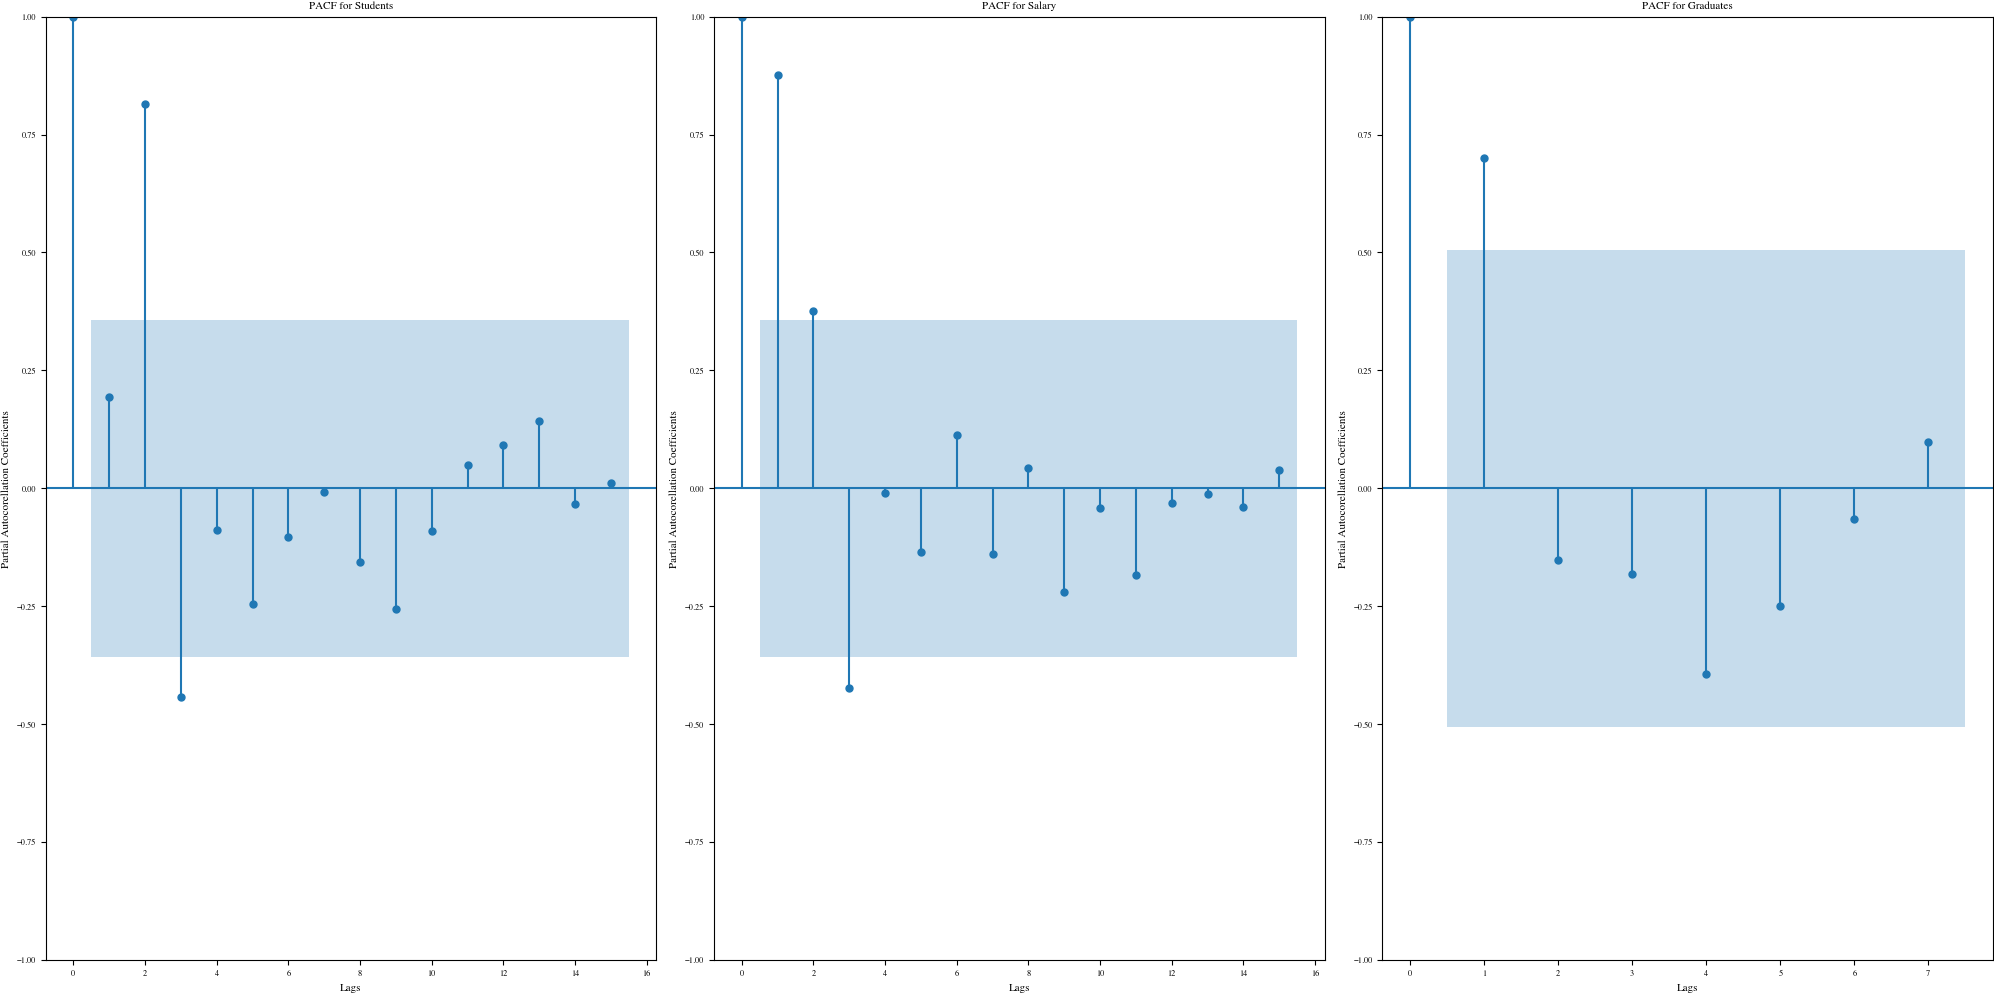

In [7]:
fig, ax = plt.subplots(figsize=(20,10), ncols=3, nrows=1)

ax[0].set_xlabel("Lags")
ax[0].set_ylabel("Partial Autocorellation Coefficients")

ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Partial Autocorellation Coefficients")

ax[2].set_xlabel("Lags")
ax[2].set_ylabel("Partial Autocorellation Coefficients")

plot_pacf(totalStudents, title='PACF for Students', ax=ax[0]);

plot_pacf(inflationAdjustedGrossSalary, title='PACF for Salary', ax=ax[1]);

plot_pacf(graduatesInBW, title='PACF for Graduates', ax=ax[2]);

fig.savefig(os.path.join(FIG_DIR, "PACF_plots_for_students_salary_graduates.pdf"))

As you can see in the plot the most promising lag for students and salary is lag 3.

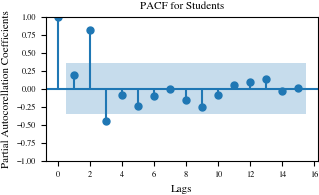

In [8]:
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlabel("Lags")
ax.set_ylabel("Partial Autocorellation Coefficients")
plot_pacf(totalStudents, title='PACF for Students', ax=ax);
fig.savefig(os.path.join(FIG_DIR, "pacf_plot.pdf"))

# Information criterion optimization

## Finding optimal values for AIC and BIC in our VAR model

In [9]:
model = VAR(completeDataDF)

results = model.select_order(6)
print('AIC: ', results.aic)
print('BIC: ', results.bic)

AIC:  6
BIC:  6


/Users/paulkaifler/miniconda3/envs/data_literacy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/paulkaifler/miniconda3/envs/data_literacy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Bayesian Information Criterion (BIC)
Using the suggested lags value from BIC (which is 6), results in a smoothed curve, because BIC penalizes complexity more strongly and thus may suggest simpler models (with fewer lags).

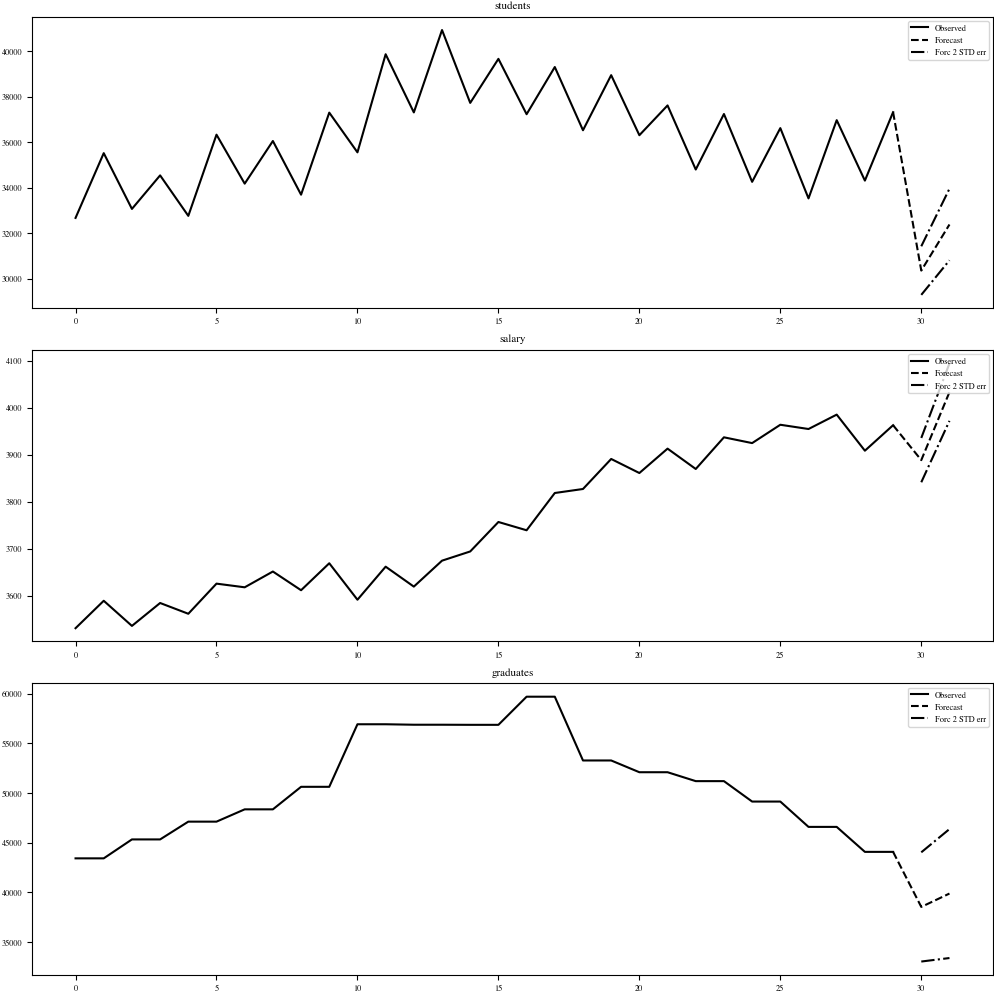

In [10]:
PAST_STEPS = 6
PREDICTION_STEPS = 2
results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = data[-PAST_STEPS:]  # Use the last available values as lagged values
forecast = results.plot_forecast(steps=PREDICTION_STEPS)

### Akaike Information Criterion (AIC)  
Using the suggested lags value from AIC (which is 5), results in a smoothed curve, because AIC tends to favor more complex models (with more lags).

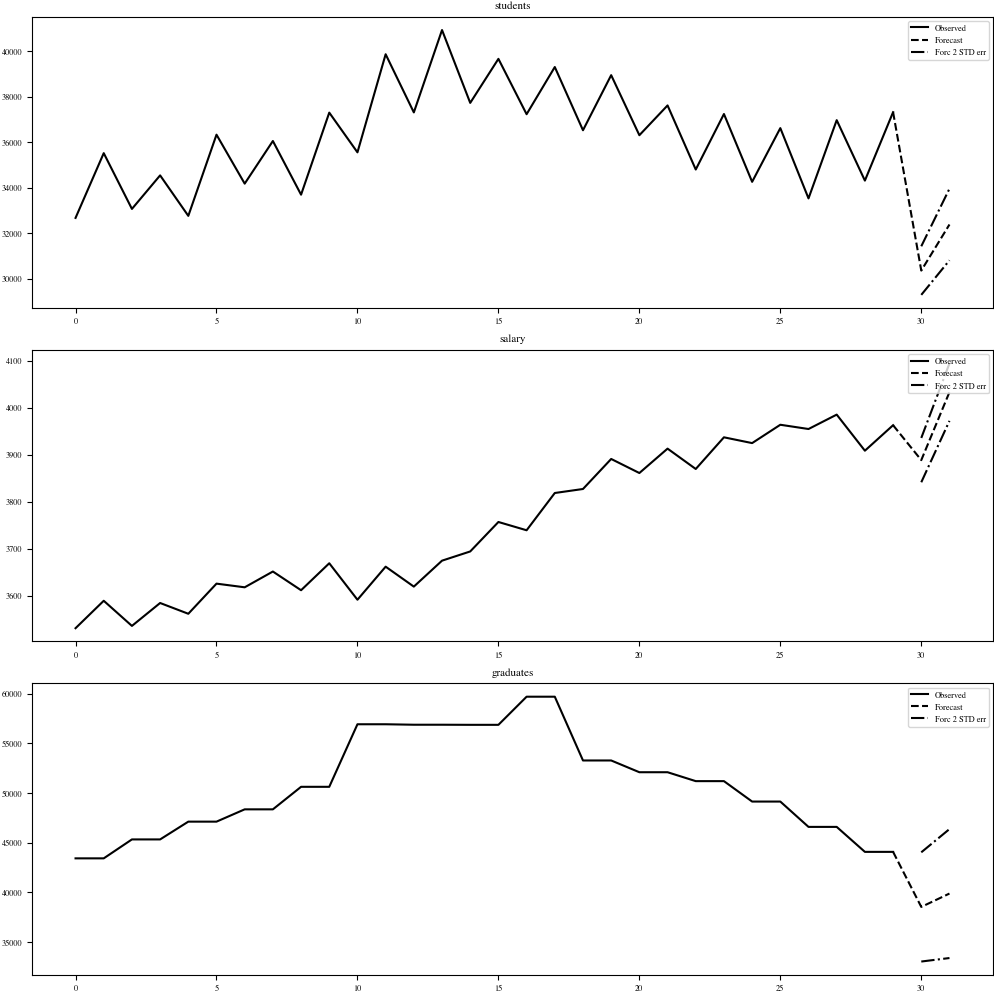

In [11]:
PAST_STEPS = 6
PREDICTION_STEPS = 2
results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = data[-PAST_STEPS:]  # Use the last available values as lagged values
forecast = results.plot_forecast(steps=PREDICTION_STEPS)

## Optimization of the hyperparameter lag
The VAR model has one hyperparameter p which can be optimized. If the lag size increases the complexity of the model increases. 
We compute the percentage difference between true value and the prediction and accumulate those for each lag over all predictions. Then we plot this as a line graph and
optimize for the minimal value for the students percentage error.

In [12]:
courses = getAllCourses() # if you use all options, dont put that in the title down marked  there
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = courses, years = interestingYears)

inflationAdjasutedGrossSalary = getInflationAdjustedGrossSalaries(SECTORS)
salaries = getSalaries()
SALARY_YEARS = salaries.index.levels[2]

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2
#Use average of 2011 and 2013 for 2012
#graduatesInBW[5] = newVal

#Use the average and add 1/4 of the missing students to 2012 and the next 3 years
diff = graduatesInBW[5] - newVal
graduatesInBW[5] = newVal + diff/4
graduatesInBW[6] = graduatesInBW[6] + diff/4
graduatesInBW[7] = graduatesInBW[7] + diff/4
graduatesInBW[8] = graduatesInBW[8] +  diff/4


completeData = np.column_stack((totalStudents, inflationAdjustedGrossSalary, graduatesInBW.repeat(2)))
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STEPS])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'salary', 'graduates'])

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


In [13]:
def computePercentageDifference(forecast,testData):
    """ computes the percentage difference between prediction and truth value

    Args:
        forecast (np.array): predicted data
        testData (np.array): true data

    Returns:
        np.array: percentage difference between truth value and prediction
    """
    absDiffernce = abs(forecast - testData)
    return (absDiffernce / testData) * 100

In [14]:
def computeAllPercentages():
    """ compute all percentage differences for lag 1 to 6

    Returns:
        np.array: percentage differences for lag 1 to 6
    """
    percentageDifferences = []
    for lags in range(1,7):
        results = fitVarModelCompleteDataset(completeData, lags)
        forecast, lower, upper = predictWithData(results, trainData[-lags:], PREDICTION_STEPS)
        percentageDifference = computePercentageDifference(forecast,testData).sum(axis=0)
        percentageDifferences.append(percentageDifference)
    return np.array(percentageDifferences)


def getStudentsDifferenceAsPercent(allPercentages):
    """get percentage difference for students 

    Args:
        allPercentages (np.array): all Predictions for lag 1 to 6

    Returns:
        np.array: percentage difference for students as 1d array
    """
    return allPercentages[:,0].transpose() / 100

def getSalaryDifferenceAsPercent(allPercentages):
    """get percentage difference for salary 

    Args:
        allPercentages (np.array): all Predictions for lag 1 to 6

    Returns:
        np.array: percentage difference for salary as 1d array
    """
    return allPercentages[:,1].transpose() / 100

def getGraduatesDifferenceAsPercent(allPercentages):
    """get percentage difference for graduates 

    Args:
        allPercentages (np.array): all Predictions for lag 1 to 6

    Returns:
        np.array: percentage difference for graduates as 1d array
    """
    return allPercentages[:,2].transpose() / 100


allPercentageDifferences = computeAllPercentages()

studentPercentageDifferences = getStudentsDifferenceAsPercent(allPercentageDifferences)
salaryPercentageDifferences = getSalaryDifferenceAsPercent(allPercentageDifferences)
graduatesPercentageDifferences = getGraduatesDifferenceAsPercent(allPercentageDifferences)

print(allPercentageDifferences/100)

[[0.06303814 0.00707778 0.06042485]
 [0.03607477 0.00804398 0.05035925]
 [0.02995787 0.00806625 0.05016981]
 [0.02256845 0.00873894 0.0517276 ]
 [0.00567746 0.00137171 0.03072927]
 [0.01002508 0.00273632 0.01735097]]


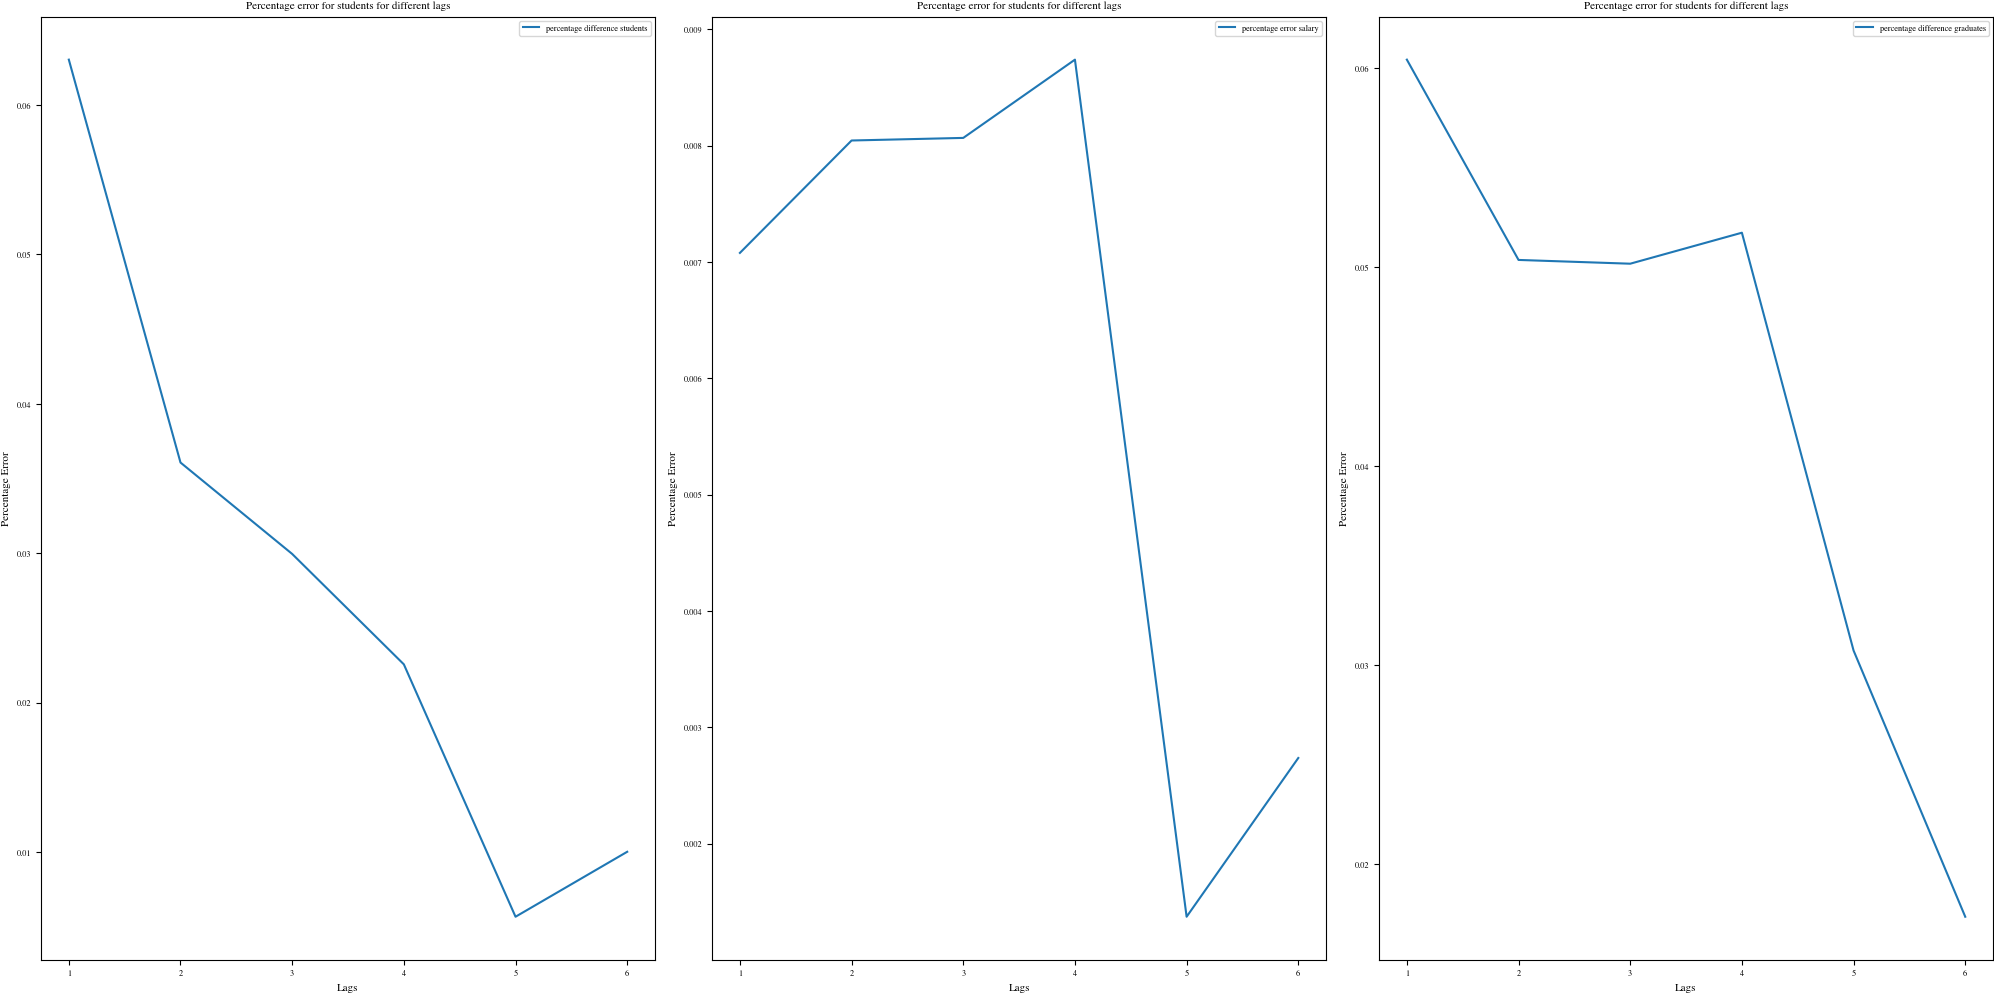

In [15]:
plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=3, usetex=False))
fig, ax = plt.subplots(figsize=(20,10),nrows=1, ncols=3)

ax[0].set_title("Percentage error for students for different lags")
ax[0].plot(range(1,7),studentPercentageDifferences, label="percentage difference students")
ax[0].set_ylabel("Percentage Error")
ax[0].set_xlabel("Lags")
ax[0].legend();

ax[1].set_title("Percentage error for students for different lags")
ax[1].plot(range(1,7),salaryPercentageDifferences, label="percentage error salary")
ax[1].set_ylabel("Percentage Error")
ax[1].set_xlabel("Lags")
ax[1].legend();

ax[2].set_title("Percentage error for students for different lags")
ax[2].plot(range(1,7),graduatesPercentageDifferences, label="percentage difference graduates")
ax[2].set_ylabel("Percentage Error")
ax[2].set_xlabel("Lags")
ax[2].legend();

fig.savefig(os.path.join(FIG_DIR, f"optimization_percentage_error_{PREDICTION_STEPS}_steps.pdf"))

### Analysis
As we want to predict the students, we are minimizing the percentage differnence students function. This leads us to an optimal lag of 5.

### Increase the prediction steps to 4

In [16]:
PREDICTION_STEPS = 4
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STEPS])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'salary', 'graduates'])

In [17]:
allPercentageDifferences = computeAllPercentages()

studentPercentageDifferences = getStudentsDifferenceAsPercent(allPercentageDifferences)
salaryPercentageDifferences = getSalaryDifferenceAsPercent(allPercentageDifferences)
graduatesPercentageDifferences = getGraduatesDifferenceAsPercent(allPercentageDifferences)

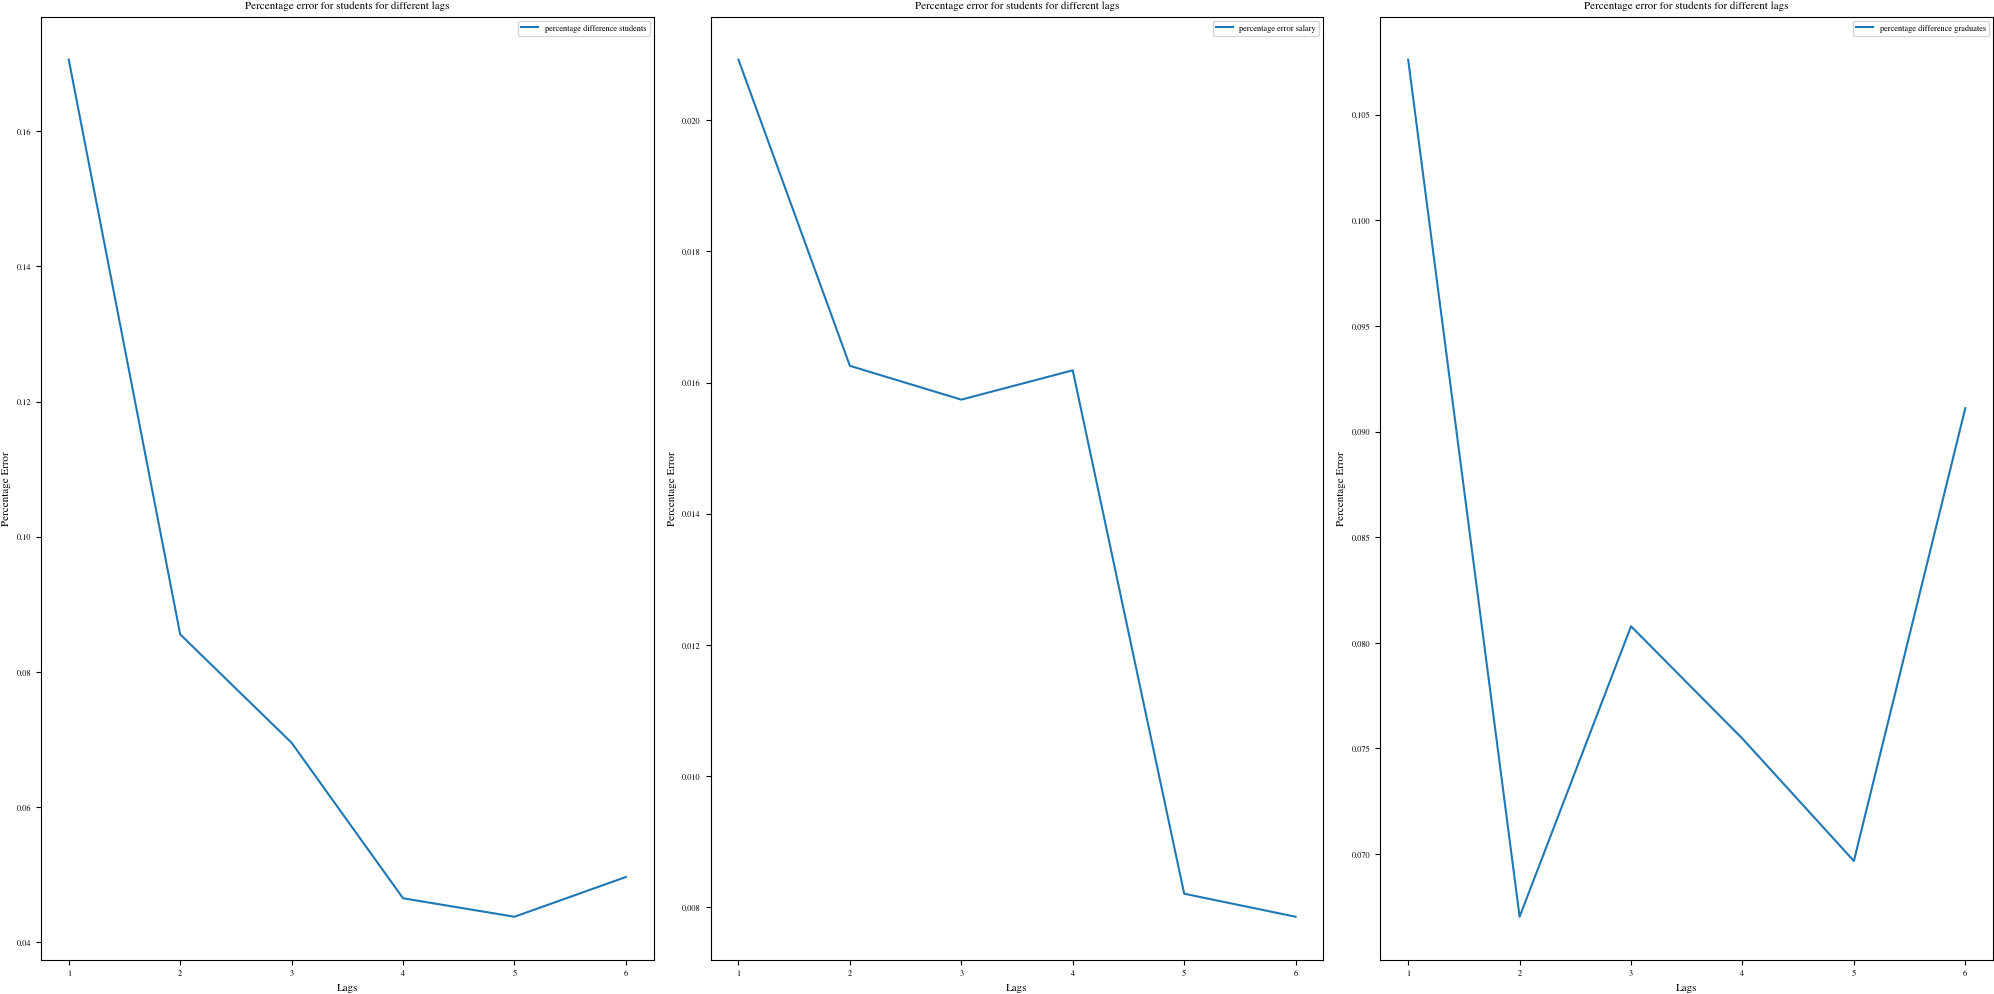

In [18]:
plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=3, usetex=False))
fig, ax = plt.subplots(figsize=(20,10),nrows=1, ncols=3)

ax[0].set_title("Percentage error for students for different lags")
ax[0].plot(range(1,7),studentPercentageDifferences, label="percentage difference students")
ax[0].set_ylabel("Percentage Error")
ax[0].set_xlabel("Lags")
ax[0].legend();

ax[1].set_title("Percentage error for students for different lags")
ax[1].plot(range(1,7),salaryPercentageDifferences, label="percentage error salary")
ax[1].set_ylabel("Percentage Error")
ax[1].set_xlabel("Lags")
ax[1].legend();

ax[2].set_title("Percentage error for students for different lags")
ax[2].plot(range(1,7),graduatesPercentageDifferences, label="percentage difference graduates")
ax[2].set_ylabel("Percentage Error")
ax[2].set_xlabel("Lags")
ax[2].legend();

fig.savefig(os.path.join(FIG_DIR, f"optimization_percentage_error_{PREDICTION_STEPS}_steps.pdf"))